# Load Libs

In [1]:
### Load Python Lib##### 
########
import numpy as np
from math import *
import matplotlib.pyplot as plt
from random import gauss, randint
from matplotlib import rc
from matplotlib.ticker import FixedLocator, MultipleLocator, FormatStrFormatter
import time
from scipy.special import spence
import scipy.optimize
from scipy import stats
import itertools

#very import to enable this so the plots can be showed in the page
get_ipython().magic(u'matplotlib inline')

# Use LaTeX font.
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman'],'size':20})

import matplotlib.font_manager as font_manager
font_prop = font_manager.FontProperties(size=12)

Deg2Rad = 3.1415926/180.0

# Load MC Data

In [2]:
### Loading the theoretical calculations
filename1 = 'database/n_asym_0_fine12.dat'
lines1 = open(filename1,'r').readlines()

N = 7
W = np.zeros(N, dtype=float)
Q2 = np.zeros(N, dtype=float)
x = np.zeros(N, dtype=float)
t = np.zeros(N, dtype=float)
Epsilon = np.zeros(N, dtype=float)
R = np.zeros(N, dtype=float)
F = np.zeros(N, dtype=float)     
XS = np.zeros(N, dtype=float)  
Asym= np.zeros(N, dtype=float)  
Astat = np.zeros(N, dtype=float) 
N_out = np.zeros(N, dtype=float)   
N_raw = np.zeros(N, dtype=float)   
N_pim = np.zeros(N, dtype=float)   

N1 = 12
N2 = 12
Bin = (N, N1, N2)
PhiS = np.zeros(Bin, dtype=float)
PhiH = np.zeros(Bin, dtype=float)
Ncnt = np.zeros(Bin, dtype=float)
Nstat = np.zeros(Bin, dtype=float)

#BinS = np.zeros((N, N1), dtype=int)
#BinH = np.zeros((N, N2), dtype=int)

## Reading in each -t bin
N_Bin =0
Q2_avg = 0.0
W_avg = 0.0
for i in range(0, N):
    values=lines1[N_Bin].split()
    values = np.array(values,dtype=float)
    Q2[i]=(values[1])
    x[i]=(values[2])
    W[i]=(values[3])
    t[i]=(values[4])
    Epsilon[i]=(values[5])
    R[i]=(values[6])
    F[i]=(values[7])
    XS[i]=(values[8])
    Asym[i]=(values[9])
    Astat[i]=(values[10])
    N_out[i]=(values[11])
    N_raw[i]=(values[12])
    
    Q2_avg += Q2[i]
    W_avg += W[i]
    
    ## Reading in Phi_S and Phi_h bins for each -t bin
    for j in range(0, N1):
        for k in range(0, N2):
            N_phi = (N_Bin+1) + k + j*N2
            values=lines1[N_phi].split()
            values = np.array(values, dtype=float)
                       
            if j!=int(values[0]) or k!=int(values[1]):
               print "*** ERROR, j!=%d/%d, k!=%d/%d"%(j, int(values[0]), k, int(values[1]))
            
            PhiS[i][j][k] = values[2] * Deg2Rad
            PhiH[i][j][k] = values[3] * Deg2Rad
            Ncnt[i][j][k] = values[4]
            Nstat[i][j][k] = values[5]
            #print "i=%d: %d  %d  %12.4f  %12.4f  %12.4e  %12.4e"%(i,j,k, PhiS[i][j][k]/Deg2Rad, PhiH[i][j][k]/Deg2Rad, Ncnt[i][j][k], Nstat[i][j][k])  
    
    N_Bin+=N1*N2 + 1
    
Q2_avg /= N
W_avg /=N

# Asymmetry Fitting

## Load Data from one -t bin

In [3]:
## Load only one bin
def LoadData(iii):
    phi_S1 = np.zeros((N1,N2), dtype=float)
    phi_H1 = np.zeros((N1,N2), dtype=float)
    F_UT1 = np.zeros((N1,N2), dtype=float)
    dF_UT1 = np.zeros((N1,N2), dtype=float)
    F_UU1 = np.zeros((N1,N2), dtype=float)
    F_UT_TEST1 = np.zeros((N1,N2), dtype=float)
    for j in range(0, N1):
        for k in range(0,N2):
            phi_S1[j][k] = PhiS[iii][j][k]
            phi_H1[j][k] = PhiH[iii][j][k]
            #F_UT[j][k] = Ncnt[iii][j][k]
            if Nstat[iii][j][k]<1.0:
                F_UT1[j][k] = 0.0
                dF_UT1[j][k] = 0.0
            else:
                F_UT1[j][k] = (Ncnt[iii][j][k])/Nstat[iii][j][k]
            if Ncnt[iii][j][k]<1.0:
                dF_UT1[j][k] = 0.0
            else:
                dF_UT1[j][k] = 1./sqrt(Ncnt[iii][j][k])

            F_UU1[j][k] = Nstat[iii][j][k]
            #dF_UT1[j][k] = 0.0000001
        
            F_UT_TEST1[j][k] = 1.0 + Asym[iii] * sin(3.0*phi_S1[j][k]+phi_H1[j][k])
            #if j==2 and k==2:
            #    print "A_UT = %f / %f,  R = %f"%(F_UT[j][k],F_UT_TEST[j][k],F_UT[j][k]/F_UT_TEST[j][k])
    return phi_S1, phi_H1, F_UT1, dF_UT1

## Using LeatSQ Fit

### Fitting Function

In [21]:
## Define fitting function by adding different angular modules and their asymmetries
def func(parms):
    global iter
    res = []
    a = parms[0]
    b = parms[1]

    chi2=0.0
    for j in range(0, N1):
        for k in range(0,N2):
            #constant term corresponds to unpolarized XS, =1 if normalized
            asym = a+(b * sin(3*phi_S[j][k] + phi_H[j][k])) ##A_UT^sin(3phi_H+phi_S)
            err = (asym-F_UT[j][k])/dF_UT[j][k]
            res.append(err)
            chi2 += err*err 
            
    iter += 1
    return res

### Do the LeastSQ fit:

In [22]:
I=3

In [23]:
## Fitting
ii=I
phi_S, phi_H, F_UT, dF_UT = LoadData(ii)    

coef_init = [1.0, Asym[ii]]
#coef_init = Asym[ii]
iter = 0
tol=1e-6
start=time.clock()
results, cov, infodict, mesg, ier = scipy.optimize.leastsq(func, coef_init, full_output=1, ftol=tol)

A_UU = results[0]
A_UT = results[1]
#A_UT = results[0]

#vec = [1,0]
#err_UT = 
dA_UT = 0.0
dA_UU = 0.0
chi2_AUT = (infodict['fvec'][0:]**2).sum()
#chi2_AUU = (infodict['fvec'][N1*N2:N1*N2+1]**2).sum()
ndof = len(infodict['fvec'])
print "chi2 = %f/%d"%(chi2_AUT,ndof)

print "I=%d, A_avg = %f+/-%f,  A_fit = %f, A_UU = %f/%f"%(ii, Asym[ii],Astat[ii], A_UT, A_UU, 1 )
#print "A = %f,  A_fit = %f"%(Asym[I], A_UT )
    
#    return A_UT, dA_UT, A_UU, dA_UU, chi2_AUT, ndof

chi2 = 91.193706/144
I=3, A_avg = -0.236200+/-0.007060,  A_fit = -0.209438, A_UU = 0.999427/1.000000


In [24]:
print cov

[[  1.88690930e-05   4.75016065e-06]
 [  4.75016065e-06   3.78634000e-05]]


## Using Maximum-Likelihood Fit

In [41]:
ii=4
phi_S, phi_H, F_UT, dF_UT = LoadData(ii)   

SUM = 0.0
for j in range(0, N1):
    for k in range(0,N2):    
        SUM+= F_UT[j][k]

In [42]:
print SUM

143.694998936


### Fitting Function 1:

In [78]:
 def likfunc1(parms):
    a = parms[0]
    b = parms[1]
    sigma = parms[2]

    asym_fit=np.zeros(N1*N2, dtype=float)
    asym_data=np.zeros(N1*N2, dtype=float)
    N=0
    for j in range(0, N1):
        for k in range(0,N2):
            #constant term corresponds to unpolarized XS, =1 if normalized
            asym_fit[N]  = a+(b * sin(3*phi_S[j][k] + phi_H[j][k])) ##A_UT^sin(3phi_H+phi_S)
            asym_data[N] = F_UT[j][k]
            N+=1            
    L = -0.5*np.sum( stats.norm.logpdf(asym_fit, loc=asym_data, scale=sigma ) )
    return L

### Fitting Function 2:

In [79]:
def likfunc2(parms):
    a = parms[0]
    b = parms[1]
    #sigma=parms[2]

    L = 0
    for j in range(0, N1):
        for k in range(0,N2):
            asym  = a+(b * sin(3*phi_S[j][k] + phi_H[j][k])) ##A_UT^sin(3phi_H+phi_S)
            L += np.log((asym))
    L -= np.log(N1*N2*SUM)
    L*=-1.0
    
    return L

### Do the ML Fit:

In [86]:
## Fitting
lik_coeff=[1.0, Asym[I], 1.0]

METH = 'L-BFGS-B'
#METH = 'Nelder-Mead'
#METH = 'SLSQP'
#METH ='Powell' 
#METH ='CG'
#METH ='BFGS'
#METH ='Newton-CG'
#METH ='TNC'
#METH ='COBYLA'

lik_model = scipy.optimize.minimize(likfunc1, lik_coeff, method=METH, jac=None, hess=True, options={'disp': True})

A_UU = lik_model['x'][0]
A_UT = lik_model['x'][1]
Sigma = lik_model['x'][2]

print "A_avg = %f,  A_fit = %f, A_UU = %f, Sigma=%f"%(Asym[I], A_UT, A_UU, Sigma )

A_avg = -0.236200,  A_fit = -0.220469, A_UU = 0.998034, Sigma=0.074277


In [87]:
print lik_model

      fun: nan
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([   1.98794226, -118.55496922,  595.66675645])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 104
      nit: 1
   status: 2
  success: False
        x: array([ 0.99803426, -0.22046916,  0.07427716])


# Plotting

## Load data into 1D

In [23]:
## Save two-D into one-D
Angle  = np.zeros(N1*N2, dtype=float)
A_Bin  = np.zeros(N1*N2, dtype=float)
dA_Bin = np.zeros(N1*N2, dtype=float)
Bin = np.zeros(N1*N2, dtype=int)
l=0
for j in range(0, N1):
    for k in range(0,N2):
        l = k+j*N1
        Angle[l] = sin(3.0*phi_S[j][k] + phi_H[j][k])
        A_Bin[l] = F_UT[j][k]
        dA_Bin[l] = dF_UT[j][k]
        Bin[l] = l


## Asym vs. $\phi_S$ or $\phi_h$

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


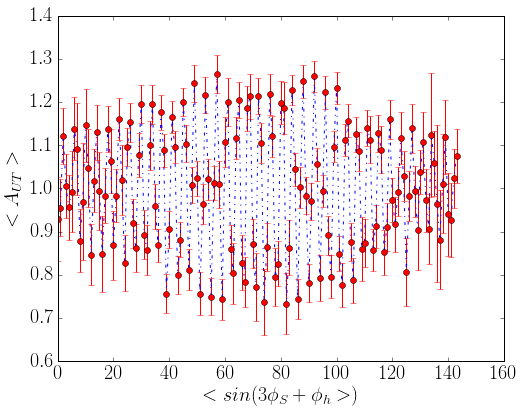

In [24]:
f,axes1 = plt.subplots(1,1, sharex=True, figsize=(8, 6))
f.subplots_adjust(bottom=0.1, top=0.9, hspace=0.02)

# Subplot for Asym.
axes1.plot(Bin, A_Bin, 'k-.', color='blue')
axes1.errorbar(Bin, A_Bin, yerr=dA_Bin, fmt='o',color='red')

axes1.set_xlabel('$<sin(3\phi_S+\phi_h>$)') # label, y-axis
#axes1.set_xlim(0.05, 1.0)
axes1.set_ylabel('$<A_{UT}>$') # label, y-axis
#axes1.set_ylim(-0.35, 0.0)

#axes1.text(0.8, -0.25, r'$<Q^{2}>=%3.2f~GeV^{2},<W>=%3.2f~GeV$'%(Q2_avg, W_avg))
axes1.legend(bbox_to_anchor=(0.175, 1.0), loc=2, prop={'size':18},borderaxespad=0., numpoints=1)

#plt.savefig('bin_asym_t%s_fermi_noFR.png'%(prd))
#plt.savefig('bin_asym_t%s_fermi_noFR.pdf'%(prd))

# Asym vs -t

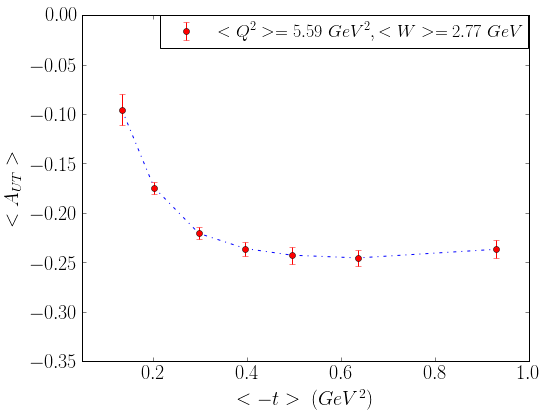

In [25]:
f,axes1 = plt.subplots(1,1, sharex=True, figsize=(8, 6))
f.subplots_adjust(bottom=0.1, top=0.9, hspace=0.02)

# Subplot for Asym.
axes1.plot(t, Asym, 'k-.', color='blue')
axes1.errorbar(t, Asym, yerr=Astat, fmt='o',color='red',label='$<Q^{2}>=%3.2f~GeV^{2},<W>=%3.2f~GeV$'%(Q2_avg, W_avg))

axes1.set_xlabel('$<-t>~(GeV^{2}$)') # label, y-axis
axes1.set_xlim(0.05, 1.0)
axes1.set_ylabel('$<A_{UT}>$') # label, y-axis
axes1.set_ylim(-0.35, 0.0)

#axes1.text(0.8, -0.25, r'$<Q^{2}>=%3.2f~GeV^{2},<W>=%3.2f~GeV$'%(Q2_avg, W_avg))
axes1.legend(bbox_to_anchor=(0.175, 1.0), loc=2, prop={'size':18},borderaxespad=0., numpoints=1)

#plt.savefig('bin_asym_t%s_fermi_noFR.png'%(prd))
#plt.savefig('bin_asym_t%s_fermi_noFR.pdf'%(prd))